<a href="https://colab.research.google.com/github/sobir-git/some-credit-scoring-tasks/blob/main/task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost imblearn seaborn geopy -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -j -o /content/drive/MyDrive/tmp/task_ml.zip

Mounted at /content/drive
Archive:  /content/drive/MyDrive/tmp/task_ml.zip
  inflating: ._task                  
  inflating: credit_test.csv         
  inflating: ._credit_test.csv       
  inflating: merchants_train.csv     
  inflating: ._merchants_train.csv   
  inflating: .DS_Store               
  inflating: ._.DS_Store             
  inflating: task_description.md     
  inflating: ._task_description.md   
  inflating: credit_train.csv        
  inflating: ._credit_train.csv      
  inflating: merchants_test.csv      
  inflating: ._merchants_test.csv    
  inflating: transactions.csv        
  inflating: ._transactions.csv      


In [3]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
encoding='CP1251'
dtype={'living_region': str}
train_data = pd.read_csv("credit_train.csv", encoding=encoding, sep=';', dtype=dtype)
test_data = pd.read_csv("credit_test.csv", encoding=encoding, sep=';', dtype=dtype)
train_data

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,48,MAR,UMN,"59998,00",10,1.60,"0,770249",GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,2,F,28,MAR,UMN,"10889,00",6,1.10,"0,248514",GRD,МОСКВА,43000.0,2.0,0.0,0
2,3,M,32,MAR,SPC,"10728,00",12,1.10,"0,459589",SCH,ОБЛ САРАТОВСКАЯ,23000.0,5.0,0.0,0
3,4,F,27,DIV,SPC,"12009,09",12,1.10,"0,362536",GRD,ОБЛ ВОЛГОГРАДСКАЯ,17000.0,2.0,0.0,0
4,5,M,45,MAR,SPC,"16908,89",10,1.10,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,25000.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170741,170742,F,27,UNM,SPC,"64867,00",12,1.10,"0,535257",GRD,РЕСПУБЛИКА ТАТАРСТАН,40000.0,6.0,0.0,0
170742,170743,F,24,MAR,SPC,"17640,00",6,1.60,"0,573287",SCH,САНКТ-ПЕТЕРБУРГ Г,30000.0,1.0,0.0,0
170743,170744,F,31,UNM,SPC,"27556,47",10,1.32,"0,416098",GRD,ПРИМОРСКИЙ КРАЙ,40000.0,1.0,0.0,0
170744,170745,F,53,DIV,PNA,"6189,00",12,1.10,"0,482595",SCH,ПЕНЗЕНСКАЯ ОБЛ,31000.0,2.0,0.0,0


In [4]:

def normalize_living_region(item):
    item = item.upper()
    item = item.replace("ОБЛАСТЬ", "ОБЛ").replace("ГОРОД", "Г").replace("РЕСПУБЛИКА", "РЕСП").replace("РЕСП.", "РЕСП")
    item = item.replace("/", " ").replace("  ", " ").replace(" - ", "-")
    parts = item.split()

    for category in ["ОБЛ", "КРАЙ", "Г", "РЕСП"]:
        if category in parts:
            break
    else:
        category = None
    
    if category:
        parts.remove(category)

    name = ' '.join(parts)

    return name, category

# train_data['living_region_name'], train_data["living_region_category"] = zip(*train_data['living_region'].apply(normalize_living_region))
# train_data

In [5]:
# Preprocessing
def preprocess_data(df):
    df["credit_sum"] = df["credit_sum"].str.replace(',', '.').astype(float)
    df["score_shk"] = df["score_shk"].str.replace(',', '.').astype(float)
    return df


# Feature engineering
def create_features(df):
    # Credit to income ratio
    df['credit_income_ratio'] = df['credit_sum'] / df['monthly_income']

    # Average credit per loan
    df['avg_credit_per_loan'] = df['credit_sum'] / df['credit_count']

    # Divide the monthly income by the credit sum to get an idea of the client's ability to repay the loan.
    df['income_to_credit_ratio'] = df['monthly_income'] / df['credit_sum']

    # Calculate the loan burden by dividing the credit sum by the loan term (credit_month).
    df['loan_burden'] = df['credit_sum'] / df['credit_month']

    # Divide the credit sum by the client's monthly income to understand the proportion of income utilized for the loan.
    df['credit_utilization'] = df['credit_sum'] / df['monthly_income']

    # Combine marital_status and education into a single feature to capture the interaction between the two.
    df['marital_education'] = df['marital_status'] + '_' + df['education']
    cat_features.append('marital_education')

    # Calculate the length of the client's credit history by subtracting the client's age from the credit_count.
    df['credit_history_length'] = df['age'] - df['credit_count']

    def family_members(marital_status):
        if marital_status == 'MAR':
            return 2
        elif marital_status == 'DIV':
            return 1
        else:
            return 1

    df['family_members'] = df['marital_status'].apply(family_members)
    df['income_per_family_member'] = df['monthly_income'] / df['family_members']

    def is_managerial(position):
        if position in ['DIR', 'ATP']:
            return 1
        else:
            return 0

    df['is_managerial'] = df['job_position'].apply(is_managerial)
    cat_features.append('is_managerial')

    def get_education_level(education):
        if education == 'SCH':
            return 'elementary'
        elif education == 'GRD':
            return 'high_school'
        else:
            return 'higher_education'

    df['education_level'] = df['education'].apply(get_education_level)
    cat_features.append('education_level')

    big_cities = ['МОСКВА', 'САНКТ-ПЕТЕРБУРГ']
    df['is_big_city'] = df.apply(lambda x: int(x.living_region in big_cities), axis=1) 

    df['tariff_id_numeric'] = df['tariff_id'].astype('float')

    df['living_region'] = df['living_region'].astype(str)
    df['living_region_name'], df["living_region_category"] = zip(*df['living_region'].apply(normalize_living_region))
    cat_features.append('living_region_name')
    cat_features.append('living_region_category')

    return df


cat_features = ['gender', 'marital_status', 'job_position', 'education', 'living_region', 'tariff_id']

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

train_data = create_features(train_data)
test_data = create_features(test_data)

# Convert categorical columns to string type
for feat in cat_features:
    train_data[feat] = train_data[feat].astype(str)
    test_data[feat] = test_data[feat].astype(str)

train_data

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,...,marital_education,credit_history_length,family_members,income_per_family_member,is_managerial,education_level,is_big_city,tariff_id_numeric,living_region_name,living_region_category
0,1,M,48,MAR,UMN,59998.00,10,1.6,0.770249,GRD,...,MAR_GRD,47.0,2,15000.0,0,high_school,0,1.60,КРАСНОДАРСКИЙ,КРАЙ
1,2,F,28,MAR,UMN,10889.00,6,1.1,0.248514,GRD,...,MAR_GRD,26.0,2,21500.0,0,high_school,1,1.10,МОСКВА,None
2,3,M,32,MAR,SPC,10728.00,12,1.1,0.459589,SCH,...,MAR_SCH,27.0,2,11500.0,0,elementary,0,1.10,САРАТОВСКАЯ,ОБЛ
3,4,F,27,DIV,SPC,12009.09,12,1.1,0.362536,GRD,...,DIV_GRD,25.0,1,17000.0,0,high_school,0,1.10,ВОЛГОГРАДСКАЯ,ОБЛ
4,5,M,45,MAR,SPC,16908.89,10,1.1,0.421385,SCH,...,MAR_SCH,44.0,2,12500.0,0,elementary,0,1.10,ЧЕЛЯБИНСКАЯ,ОБЛ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170741,170742,F,27,UNM,SPC,64867.00,12,1.1,0.535257,GRD,...,UNM_GRD,21.0,1,40000.0,0,high_school,0,1.10,ТАТАРСТАН,РЕСП
170742,170743,F,24,MAR,SPC,17640.00,6,1.6,0.573287,SCH,...,MAR_SCH,23.0,2,15000.0,0,elementary,0,1.60,САНКТ-ПЕТЕРБУРГ,Г
170743,170744,F,31,UNM,SPC,27556.47,10,1.32,0.416098,GRD,...,UNM_GRD,30.0,1,40000.0,0,high_school,0,1.32,ПРИМОРСКИЙ,КРАЙ
170744,170745,F,53,DIV,PNA,6189.00,12,1.1,0.482595,SCH,...,DIV_SCH,51.0,1,31000.0,0,elementary,0,1.10,ПЕНЗЕНСКАЯ,ОБЛ


In [6]:
# Retrieve GPS coordinates
from geopy.geocoders import Nominatim
from functools import lru_cache
from tqdm import tqdm

geolocator = Nominatim(user_agent="myGeocoder")

@lru_cache(maxsize=None)
def get_gps_coordinates(location):
    try:
        location_obj = geolocator.geocode(location)
        return (location_obj.latitude, location_obj.longitude)
    except:
        return (None, None)


# Wrap the living_region column with tqdm for progress bar
tqdm.pandas()


train_data['latitude'], train_data['longitude'] = zip(*train_data['living_region_name'].progress_apply(get_gps_coordinates))
test_data['latitude'], test_data['longitude'] = zip(*test_data['living_region_name'].progress_apply(get_gps_coordinates))

train_data[['living_region_name', 'longitude', 'latitude']].sample(20)


100%|██████████| 91940/91940 [00:04<00:00, 22819.13it/s]


,living_region_name,longitude,latitude
115900,САНКТ-ПЕТЕРБУРГ,30.316229,59.938732
93548,САМАРСКАЯ,142.593716,49.671625
6584,ПЕНЗЕНСКАЯ,142.142802,47.898524
152613,САМАРСКАЯ,142.593716,49.671625
8548,ОРЛОВСКАЯ,164.421527,66.997026
79653,КУРГАНСКАЯ,55.153112,51.783860
129428,ТЫВА,93.858259,51.401715
43634,СВЕРДЛОВСКАЯ,43.053558,60.479954
153772,ЧУВАШСКАЯ,47.084943,55.425992
128465,ТАТАРСТАН,50.476359,55.448217


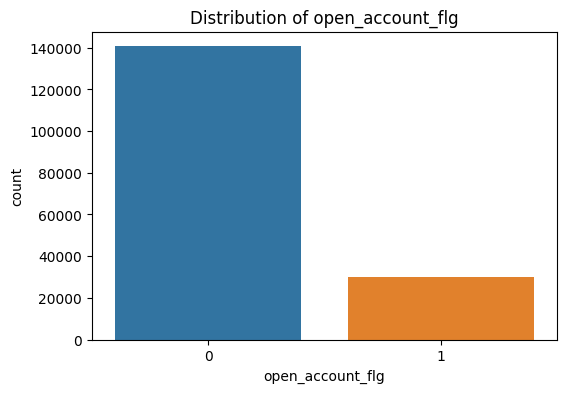

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(x='open_account_flg', data=train_data)
plt.title('Distribution of open_account_flg')
plt.show()

In [8]:
# Split data into training and validation sets
X = train_data.drop("open_account_flg", axis=1)
X = X.drop('client_id', axis=1)
y = train_data["open_account_flg"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Initialize and train the CatBoost model
model = CatBoostClassifier(iterations=1000, 
                           learning_rate=0.1,
                           depth=4, 
                           loss_function='Logloss', 
                           cat_features=cat_features, 
                           verbose=100,
                           random_state=42,
                           )

model.fit(X_train, y_train, eval_set=(X_val, y_val))

0:	learn: 0.6398171	test: 0.6397002	best: 0.6397002 (0)	total: 877ms	remaining: 14m 36s
100:	learn: 0.4001335	test: 0.3962715	best: 0.3962715 (100)	total: 37.6s	remaining: 5m 34s
200:	learn: 0.3952324	test: 0.3919980	best: 0.3919980 (200)	total: 1m 2s	remaining: 4m 8s
300:	learn: 0.3924086	test: 0.3904751	best: 0.3904751 (300)	total: 1m 25s	remaining: 3m 17s
400:	learn: 0.3902351	test: 0.3896815	best: 0.3896761 (399)	total: 1m 49s	remaining: 2m 44s
500:	learn: 0.3884777	test: 0.3891278	best: 0.3891278 (500)	total: 2m 16s	remaining: 2m 16s
600:	learn: 0.3869977	test: 0.3888916	best: 0.3888810 (565)	total: 2m 39s	remaining: 1m 45s
700:	learn: 0.3854997	test: 0.3887078	best: 0.3886494 (662)	total: 3m 4s	remaining: 1m 18s
800:	learn: 0.3841899	test: 0.3884415	best: 0.3884339 (793)	total: 3m 29s	remaining: 52s
900:	learn: 0.3830652	test: 0.3883735	best: 0.3883539 (887)	total: 3m 51s	remaining: 25.5s
999:	learn: 0.3818713	test: 0.3883080	best: 0.3882799 (966)	total: 4m 19s	remaining: 0us

be

Validation Set Metrics:
Accuracy: 0.8342
Precision: 0.6114
Recall: 0.1473
F1 Score: 0.2374
AUC-ROC: 0.7792



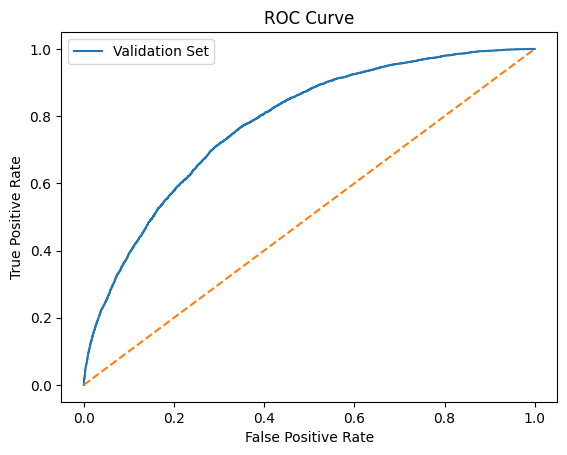

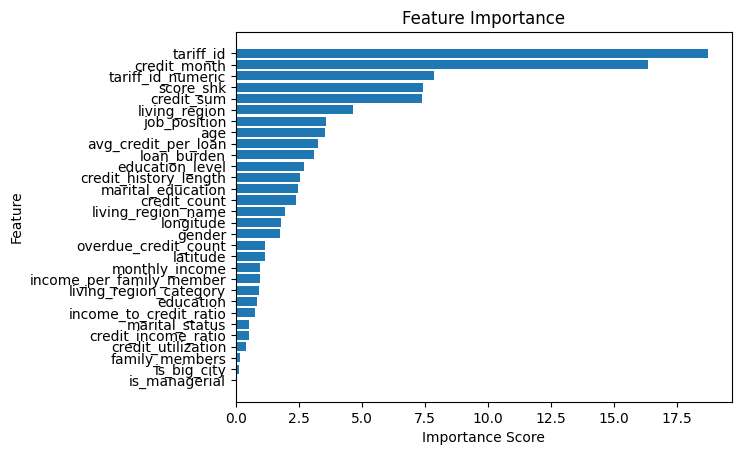

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Make predictions on the validation and test sets
y_val_pred = model.predict(X_val)

# Calculate evaluation metrics for the validation set
val_acc = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

# Print the evaluation metrics
print("Validation Set Metrics:")
print(f"Accuracy: {val_acc:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")
print(f"AUC-ROC: {val_roc_auc:.4f}")
print()

# Plot the ROC curve for both the validation and test sets
fpr_val, tpr_val, _ = roc_curve(y_val, model.predict_proba(X_val)[:, 1])

plt.plot(fpr_val, tpr_val, label='Validation Set')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Get the feature importance scores
feat_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
feat_importance = feat_importance.sort_values(by='Importance', ascending=True)

# Plot the feature importance scores
plt.barh(feat_importance['Feature'], feat_importance['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


In [19]:
# Predict for test data
test_data["open_account_flg"] = model.predict(test_data[X.columns])
test_data[['client_id', 'open_account_flg']]

,client_id,open_account_flg
0,170747,0
1,170748,0
2,170749,0
3,170750,0
4,170751,0
...,...,...
91935,262682,0
91936,262683,0
91937,262684,0
91938,262685,0
